In [1]:
import argparse, os, re, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Simulate running model as with 00train_model.py
os.chdir(Path.home() / 'Code/Python/tensormorph')
sys.path.append('../phon')
sys.path.append('./tensormorph')
from tensormorph import *

# Plotting config
plt.rcParams['image.cmap'] = 'viridis'

# Convert tensor to numpy with rounding
def t2np(x, digits=2):
    y = x.data.numpy()
    y = np.round(y, digits)
    return y

print('imported')

imported


In [6]:
%%capture
# Initialize environment
# xxx todo: read args from pkl
args_ = {#'data_dir': '/Users/colin/Projects/AMP2021/english_verbs/data',
         #'data': 'english_verb_all1',
        #'data_dir': '/Users/colin/Code/Python/tensormorph_data',
        'data': 'chamorro/chamorro_um',
         'features': 'hayes_features.csv',
         #'morphosyn': 'unimorph',
         'morphosyn': None,
         'dmorphophon': 0,
         'reduplication': False,
         'config': 'model_config.yaml'}
args = argparse.Namespace(**args_)
config = tensormorph.init(args)

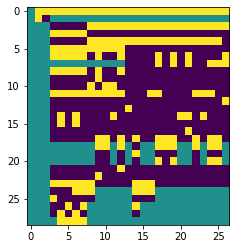

In [7]:
plt.imshow(config.F)

In [6]:
# Load model
# (if receive error, probably config option dmorphophon is set incorrectly)
#fmodel = Path.home() / 'Desktop/tmorph_output' / 'model.pt'
#fmodel = '/Users/colin/Desktop/tmorph_output/model_verb_best.pt'
#fmodel = '/Users/colin/Desktop/tmorph_output/model_noun_best.pt'
#fmodel = '/Users/colin/Desktop/tmorph_output/model_noun_best3.pt'
#fmodel = '/home/cwilso23/Desktop/tmorph_output/model.pt'
fmodel = Path.home() / 'Projects/AMP2021/english_verbs/fit/model_reg1.pt'

grammar = config.grammar
grammar.load_state_dict(torch.load(fmodel))
#grammar.eval()

<All keys matched successfully>

In [7]:
# Trace model on split
split = 'test'
dat_embed = getattr(config, f'dat_{split}')
batch = data_util.morph_batcher(dat_embed)
config.recorder = recorder.Recorder()
pred = config.grammar(batch)

('⋊ b ɛ ɹ s t • ⋉', '⟨⋊⟩ ⟨t⟩ ə ⟨d⟩ • ', '⋊ b ɛ ɹ s t t d ')
Mslot2dim_attn
           slot0
number  0.216167
person  0.296966
pos     0.671414
tense   0.762236


stem_pivot [0.01 0.01 0.02 0.   0.01 0.95 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
affix_copy [0.01 0.01 0.66 0.05 0.45 0.51 0.5  0.5  0.5  0.5  0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
affix_pivot [0.02 0.02 0.12 0.37 0.01 0.01 0.02 0.03 0.12 0.27 1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.  ]
affix_str ⟨⋊⟩ ⟨t⟩ ə ⟨d⟩ • 

('ə', -203.3)


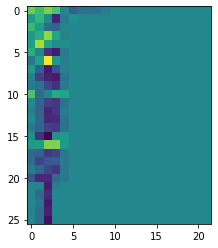

In [18]:
# Visualize stem, affix, output for batch member in split
idx = 0
Stem = config.grammar.cogrammar.stem
stem_pivot = t2np(Stem.pivot)[idx]
print(f'stem_pivot {stem_pivot}')

Affix = config.grammar.cogrammar.affix
affix_str = Affix._str()[idx]
affix_form = t2np(Affix.form[idx]) # t2np(torch.tanh(Affix.form[idx]))
affix_logprob = t2np(config.decoder(Affix.form))[idx]
affix_copy = t2np(Affix.copy)[idx]
affix_pivot = t2np(Affix.pivot)[idx]

print(f'affix_copy {affix_copy}')
print(f'affix_pivot {affix_pivot}')
print(f'affix_str {affix_str}')
print()

plt.imshow(affix_form)
#plt.imshow(affix_logprob)

posn = 2
affix_sym_logprob = list(zip(config.syms, affix_logprob[:,posn]))
affix_sym_logprob = filter(lambda x: x[0] not in ['ϵ', '⋊', '⋉'], affix_sym_logprob)
affix_sym_logprob = sorted(affix_sym_logprob, key = lambda x: -x[1])
#affix_sym_logprob = affix_sym_logprob.sort(lambda x: x[1] if x[0] not in  else -np.inf)
print(affix_sym_logprob[0])

In [28]:
params = grammar.state_dict()
phon_params = {k:v for (k,v) in params.items() if re.search('phonology', k)}
base_params = {k:v for (k,v) in params.items() if k not in phon_params}

import torch.optim as optim
optimizer = optim.Adagrad([{'params': base_params.values()},
                           {'params': phon_params.values(), 'lr':1.0e-1}], lr=1.0e-2)

In [5]:
# Morphosyn tags in train and test data
train_tags = set([ex['morphosyn_str'] for ex in config.dat_train])
test_tags = set([ex['morphosyn_str'] for ex in config.dat_test])
print(len(train_tags), len(test_tags))

1 1


In [8]:
print(grammar.morph_attender.tau.data)
print(grammar.posn_attender.tau.data)
print(grammar.decoder.tau.data)

tensor([0.0776])
tensor([1.6571])
tensor([0.7596])


('⋊ t* a t ɨ m ə • ⋉', '⟨⋊⟩ ⟨⋉⟩', '⋊ t* a t ɨ m ə ⋉')
Mslot2dim_attn
                               slot0
language-specific features  0.759694
⋊ k a m • a ⋉
⟨⋊⟩ ⟨n⟩ n ɨ tʰ a • 
⋊ k a m n ɨ n t a ⋉


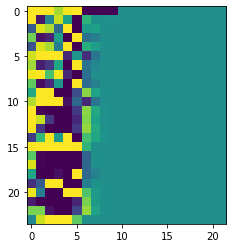

In [36]:
# Trace processing for specified data split
split = 'test'
config.recorder = recorder.Recorder()
dat_embed = getattr(config, f'dat_{split}')
batch = data_util.morph_batcher(dat_embed)
pred = config.grammar(batch)

# Stem and affix traces
stem = config.grammar.cogrammar.stem
stem_form = torch.tanh(stem.form)
stem_str = stem._str()
affix = config.grammar.cogrammar.affix
affix_form = torch.tanh(affix.form)
affix_str = affix._str()
output = config.grammar.cogrammar.output
output_form = torch.tanh(output.form)
output_str = output._str()

batch_id = 4
print(stem_str[batch_id])
print(affix_str[batch_id])
print(output_str[batch_id])
#print(stem.pivot[batch_id])
#print(affix.pivot[batch_id])
#print(affix_form[batch_id][0])
plt.imshow(affix_form[batch_id].data.numpy())

In [40]:
# Learned phonology
phon = config.grammar.cogrammar.phonology
context0 = torch.zeros(1, 1)
w_deln = phon.w_deln(context0)
print(w_deln)
print(phon)

tensor([[ 0.0268, -0.3434,  0.2209,  0.2480,  0.0454,  0.0847,  0.1221,  0.2094,
          0.0618, -0.5308,  0.1950,  0.1726,  0.1838,  0.1388,  0.1843,  0.1434,
          0.2480,  0.1452,  0.2721,  0.2705,  0.1321,  0.0131, -0.1658,  0.1461,
          0.1345,  0.1242, -0.1729,  0.0701,  0.4245,  0.2029]],
       grad_fn=<AddmmBackward>)
Phonology(
  (matcher): Matcher3(
    (matcher_prev): LiteralMatcher(
      (context2W): Linear(in_features=1, out_features=720, bias=True)
    )
    (matcher_cntr): LiteralMatcher(
      (context2W): Linear(in_features=1, out_features=720, bias=True)
    )
    (matcher_next): LiteralMatcher(
      (context2W): Linear(in_features=1, out_features=720, bias=True)
    )
  )
  (mod): Linear(in_features=1, out_features=180, bias=True)
  (w_chng): Linear(in_features=1, out_features=720, bias=True)
  (w_deln): Linear(in_features=1, out_features=30, bias=True)
  (w_epen): Linear(in_features=1, out_features=120, bias=True)
  (v_chng): Linear(in_features=1, out_

In [10]:
# Affixes
affixer = grammar.cogrammar.cogrammar.affixer
pivoter = affixer.pivoter
affix_context = affixer.affix_context
affix_context_len = torch.norm(affix_context, p=2, dim=-1)
affix_Wpivot = affixer.affix_Wpivot + affixer.affix_Wpivot0
print(np.round(affix_Wpivot[1].data.numpy(), 2))
#plt.imshow(affix_Wpivot.data)
print(affix_context_len)
print(np.round(affix_context[1].data.numpy(), 2))
plt.imshow(affix_context.data)

AttributeError: 'Affixer' object has no attribute 'affix_context'

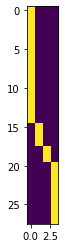

tensor([[0.2108, 0.2780, 0.9922],
        [0.6976, 0.9847, 0.7576],
        [0.9887, 0.0322, 0.2735],
        [0.9851, 0.9940, 0.5832]])


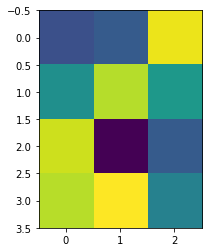

In [44]:
Mdim2units = config.morphosyn_embedder.Mdim2units
plt.imshow(Mdim2units.data)
plt.show()

Mslot2dim_attn = grammar.cogrammar.Mslot2dim_attn
print(torch.sigmoid(Mslot2dim_attn).data)
plt.imshow(Mslot2dim_attn.data)

tensor([ 0.0318, -0.8099, -0.1776,  0.1390, -0.8765,  0.2778, -0.0192, -0.3023,
        -0.1107,  0.6539,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
tensor([0.9992, 0.9985, 0.9985, 0.9956, 0.9951, 0.9739, 0.9106, 0.9469, 0.9421,
        0.5391], grad_fn=<SliceBackward>)
tensor([8.4460e-05, 1.0995e-04, 6.5580e-04, 6.0320e-03, 4.0268e-02, 6.5765e-02,
        6.6981e-02, 2.1168e-02, 1.2967e-01, 6.6927e-01],
       grad_fn=<SliceBackward>)


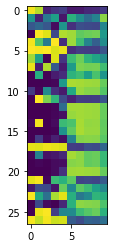

In [45]:
decoder = grammar.decoder
affixer = grammar.cogrammar.cogrammar.affixer
#context2affix_form = affixer.context2affix_form

ex = config.dat_train[0]; #print(ex)
#print(ex['morphosyn_str'])
#print(ex['morphosyn'])
Stem = morph.Morph(ex['stem'].unsqueeze(0))
tag = 'PST;FH;1[+]INCL;PL' # 'PRS;2;PL'
morphosyn, morphospec = config.morphosyn_embedder.embed(tag)
Stem, Affix = affixer(Stem, morphosyn.unsqueeze(0))
plt.imshow(Affix.form.data[0,:,:10])
print(Affix.form.data[0,1,:])
print(Affix.copy[0,:10])
print(Affix.pivot[0,:10])

case=ϵ	ϵ a ⋉

case=abl	m a n t a • ⋉

case=acc	a a ⋉

case=ben	p a p ⋉

case=causv	r a j k u ⋉

case=com	n t i n ⋉

case=compv	h h n a ⋉

case=ess	p i ⋉

case=exclv	ʎ a ⋉

case=gen	a p ⋉

case=ins	w a n ⋉ •

case=inter	p u r a ⋉

case=nom	⋉

case=priv	n n a q ⋉

case=term	a a m a ⋉

number=ϵ	ϵ a ⋉

number=pl	a a ⋉

number=sg	k a ⋉

pos=ϵ	ϵ a ⋉

pos=n	n k i k u

possession=ϵ	ϵ ϵ n

possession=pss1pe	⋉

possession=pss1pi	⋉

possession=pss1s	a r ⋉

possession=pss2p	i k k u n •

possession=pss2s	i ⋉

possession=pss3p	⋉

possession=pss3s	ϵ l ⋉

<zero>	ϵ a ⋉

['ϵ a ⋉ ⋉ ⋉ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ']


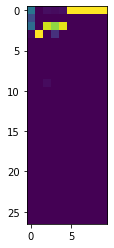

In [46]:
# Highest-probability decoding up to cumulative probability threshold
def top_sym(probs, theta=0.95):
    m, n = probs.shape
    tops = [ ]
    for r in range(n):
        prob = probs[:,r]
        #print(prob)
        indx = np.argsort(prob)[::-1]
        prob = [prob[i] for i in indx]
        cumprob = np.cumsum(prob)
        top = [(config.syms[indx[i]], prob[i]) for i in range(m)
                   if cumprob[i]<theta or i==0]
        top = '('+ '|'.join([x[0] for x in top]) +')'
        tops.append(top)
    return ' '.join(tops)

# Hard decoded string for each morphosyn embedding unit
unit2label = config.morphosyn_embedder.unit2label
for i in range(config.dmorphosyn+1):
    morphosyn1 = torch.zeros(1, config.dmorphosyn)
    if i < config.dmorphosyn:
        lab = unit2label[i]
        morphosyn1[0,i] = 1.0
    else:
        lab = '<zero>'
    Stem, Affix = affixer(Stem, morphosyn1)
    print(f'{lab}\t{Affix._str()[0]}')
    #Affix_probs = torch.softmax(decoder(Affix.form), dim=1)
    #print(f'{lab}\t{top_sym(Affix_probs.data.numpy()[0])}')
    #if lab=='person=1+incl': break
    print()

affix_tpr_raw = torch.atanh(Affix.form).data[0,:,:10].numpy()
#plt.imshow(affix_tpr_raw)
#print(np.max(affix_tpr_raw), np.min(affix_tpr_raw))

affix_logits = decoder(Affix.form)
affix_idx = decoder.decode(Affix.form)
affix_str = config.form_embedder.idvec2string(affix_idx, trim=0)
affix_probs = torch.softmax(affix_logits, dim = 1)
#plt.imshow(affix_logits.data[0,:,:10])
plt.imshow(affix_probs.data[0,:,:10])
print(affix_str)
#print(config.form_embedder.id2sym[2])

In [47]:
# Hard decoded string for each morphosyn vector and slot
morphosyns = {ex['morphosyn_str']:ex['morphosyn'] for ex in config.dat_train}
morphosyns = [(m, morphosyns[m]) for m in morphosyns.keys()]
morphosyns = sorted(morphosyns, key = lambda x: x[0])

nslot = 3
for (m_str, m) in morphosyns:
    affix_strs = [ ]
    for slot in range(nslot):
        dim_attn = torch.sigmoid(Mslot2dim_attn[:,slot])
        mask = Mdim2units @ dim_attn
        Stem, Affix = affixer(Stem, (m * mask).unsqueeze(0))
        affix_str = Affix._str()[0]
        #affix_str = re.sub('⟨.*⟩ ', '', affix_str)
        affix_strs.append(affix_str)
    print(m_str, '\t', ' + '.join(affix_strs))

#print([(dim, np.round(dim_attn[i].item(),2)) for i,dim in 
#        enumerate(config.morphosyn_embedder.dims)])

n;abl;pl 	 k u n + a ⋉ + n m n t a • ⋉
n;abl;sg 	 k i n + p + m a n t a ⋉
n;acc;pl 	 k u n + a a n a + t a n
n;acc;sg 	 k i + p + t a ⋉
n;ben;pl 	 k u n + a a ϵ a + t a ⋊ ⋉
n;ben;sg 	 k i + p + p a q
n;causv;pl 	 k u n k u + a a n + r a j k u ⋉
n;causv;sg 	 k i +  + r a ϵ ϵ u ⋉
n;com;pl 	 k u n + a ⋉ + n ⋉
n;com;sg 	 k i + p + t t i
n;compv;pl 	 k u n + a u n a + h u n a ⋉
n;compv;sg 	 k i n +  + h i n
n;ess;pl 	 k u n + a u ϵ a + p i ⋉
n;ess;sg 	 k i + p + p i ⋉
n;exclv;pl 	 k u n + a u n a + ʎ a ⋉
n;exclv;sg 	 k i + k + ʎ a ⋉
n;gen;pl 	 k u n + a a + t ⋉
n;gen;sg 	 k i + p + p ⋉
n;ins;pl 	 k u n + a a n a + w a n ⋉
n;ins;sg 	 k i + p ϵ n + w a n ⋉
n;inter;pl 	 k u n + a u n a + p u r a ⋉
n;inter;sg 	 k u + p + p u
n;nom;pl 	 k u n + a u + ⋉
n;nom;sg 	 k i +  + ⋉
n;priv;pl 	 k u n k + a ⋉ + n n a q ⋉
n;priv;sg 	 k i n + p + n n n q
n;pss1pe;abl;pl 	 j k u k ⋉ + k u n a ⋉ + m a n t a • ⋉
n;pss1pe;abl;sg 	 j k u + p + m a n t a ⋉
n;pss1pe;acc;pl 	 j k u k u + k u n a + t a ⋉
n;pss1pe;ac

In [ ]:
# todo: add labels to figures
# todo: print morphological derivation as labeled trees

         mod      deln     epen2     epen1
0   0.325556  0.271068  0.238584  0.164791
1   0.315113  0.343003  0.200809  0.141074
2   0.894280  0.007583  0.051830  0.046308
3   0.259069  0.469714  0.157760  0.113457
4   0.865021  0.042772  0.057496  0.034711
5   0.254937  0.246657  0.290963  0.207444
6   0.385221  0.490939  0.071697  0.052143
7   0.356523  0.161140  0.282876  0.199462
8   0.307890  0.298916  0.222671  0.170522
9   0.313176  0.420724  0.161215  0.104885
10  0.176209  0.122316  0.426092  0.275383
11  0.646330  0.005904  0.068093  0.279673
12  0.250810  0.171316  0.375313  0.202560
13  0.279103  0.289849  0.243026  0.188022
14  0.302009  0.157009  0.326053  0.214928
15  0.376179  0.248493  0.230132  0.145196
16  0.322330  0.241391  0.245706  0.190573
17  0.203470  0.223354  0.345532  0.227644
18  0.222287  0.120869  0.448479  0.208365
19  0.431866  0.190722  0.240082  0.137330


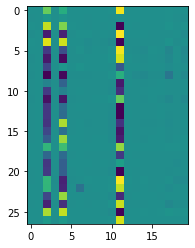

['ϵ ϵ k ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ i ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ']


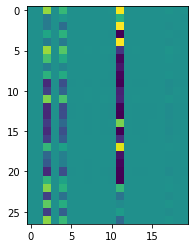

['ϵ ϵ i ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ p ϵ ϵ ϵ ϵ ϵ ϵ ϵ ϵ']


In [49]:
# Phonology module
# xxx get code for printing rules from tensorphon
phon = grammar.phonology
context0 = torch.ones(1,1)

change_logits = phon.change(context0) \
                    .view(1, phon.nchange, phon.npattern)
#print(change_logits.shape)
change_probs = torch.softmax(change_logits, dim = 1)
change_probs = pd.DataFrame(change_probs[0].t().data.numpy())
change_probs.columns = phon.change_types
print(change_probs)

w = phon.W(context0) \
        .view(1, phon.npattern)
w = torch.exp(w)
#print(w)

ftr1 = phon.ftr1(context0) \
            .view(1, config.dsym, phon.npattern)
ftr1 = torch.tanh(ftr1)
plt.imshow(ftr1[0].data)
plt.show()
print(morph.Morph(ftr1)._str(trim=0))

ftr2 = phon.ftr2(context0) \
            .view(1, config.dsym, phon.npattern)
ftr2 = torch.tanh(ftr2)
plt.imshow(ftr2[0].data)
plt.show()
print(morph.Morph(ftr2)._str(trim=0))

#matcher = phon.matcher
#matcher_cntr = matcher.matcher_cntr
#print(matcher_cntr.Wpos)
# xxx print matchers

In [41]:
X = torch.randn(10, 6)
print(X[1])
Y = X.view(-1, 3, 2)
print(Y[1])

tensor([-1.4522, -0.0627, -0.6569, -0.1416, -0.5255,  0.6240])
tensor([[-1.4522, -0.0627],
        [-0.6569, -0.1416],
        [-0.5255,  0.6240]])
